In [101]:
import importlib
import util
importlib.reload(util)
from util import *

import extraction
importlib.reload(extraction)
from extraction import *

In [77]:
import pandas as pd
from nltk import ngrams
from IPython.core.display import display, HTML

# Identify Job Ads Post Structure

last update: 2020-03-20

### Assumption:
- Sentences which belong the same section are in sequence.
- Each section only occur exactly only one time.

### Advantages:
1. Ordering of different sections does not matter.
2. May apply to different job ads websites.

### Limitataion:
1. Some sections may have overlapping issues. E.g. Responsibilities and Requirements.
2. Chinese Characters have not yet been dealt with.

### What's next:
1. Expand the tagging to sentence-wise or paragraph-wise
2. Tokenizr Chinese Characters to support job ads in Chinese

In [58]:
mapping = {
"A": "#A requirement",
"B": "#B responsibility",
"C": "#C benefit",
"D": "#D apply resume",
"E": "#E company description",
"F": "#F others",
"U": "#U unclass",
}

In [59]:
baseurl = "./processingfile/a03"
wA = json.loads(open(f'{baseurl}/wanted_{"A"}.txt', mode='r', encoding='utf8').read())
wB = json.loads(open(f'{baseurl}/wanted_{"B"}.txt', mode='r', encoding='utf8').read())
wC = json.loads(open(f'{baseurl}/wanted_{"C"}.txt', mode='r', encoding='utf8').read())
wD = json.loads(open(f'{baseurl}/wanted_{"D"}.txt', mode='r', encoding='utf8').read())
wE = json.loads(open(f'{baseurl}/wanted_{"E"}.txt', mode='r', encoding='utf8').read())
total_token_count = int(open(f'wanted_{"length"}.txt', mode='r', encoding='utf8').read())

# Testing Stage: Labelling a Job Ads with guessing section using testing Datasets 

In [148]:
df400 = get_df("./jobsdb_dump_400-500.json")

idx = 74
text = df400["jobDetail"][idx]["jobDescription"]
text = PrepText(text).get_variables()["lower_text"]
text

'our client is a well-known global technology company. we are looking for outstanding talents who are determined in developing their career in the digital marketing industry to.  join our project for a global renowned advertising company. clear career path with attractive. salary package pleasant. company culture with renowned company background. work with a dynamic and friendly team in a. great location . job duties. collect requirements from end-users. design and develop solutions to meet end-users requirement. work with other teammates to meet tight schedule / rapid changing business requirements. analyse and design systems for business problems. require excellent programming skills and customer thinking mindset. requirements. graduate work or degree in computer science or engineering a plus. hands on experience in apache spark / scala / presto / elasticsearch / hdfs is a definitely plus. knowledge in java, spring, php, vue.   js, jquery, linux shell, git, maven will be a plus. be s

In [149]:
# total_token_count = len(all_2grams)
collection = []
for i in range(len(text.split())-2):
    token = ' '.join(text.split()[i:i+2])
    # print(token)
    term_in_section = []
    probability = []
    lsA = list(filter(lambda x: x[0] == token, wA))
    lsB = list(filter(lambda x: x[0] == token, wB))
    lsC = list(filter(lambda x: x[0] == token, wC))
    lsD = list(filter(lambda x: x[0] == token, wD))
    lsE = list(filter(lambda x: x[0] == token, wE))
    
    addition = 0

    if token.find('requirements:.') != -1:
        term_in_section.append({"key": "A", "prob": 0.005})
    else:
        if len(lsA) > 0:
            term_in_section.append({"key": "A", "prob": lsA[0][1] / total_token_count + addition})

    if token.find('responsibilities:.') != -1:
        term_in_section.append({"key": "B", "prob": 0.005})
    else:
        if len(lsB) > 0:
            term_in_section.append({"key": "B", "prob": lsB[0][1] / total_token_count + addition})

    if len(lsC) > 0:
        term_in_section.append({"key": "C", "prob": lsC[0][1] / total_token_count + addition})
    if len(lsD) > 0:
        term_in_section.append({"key": "D", "prob": lsD[0][1] / total_token_count + addition})
    if len(lsE) > 0:
        term_in_section.append({"key": "E", "prob": lsE[0][1] / total_token_count + addition})
    collection.append({
        "token": token,
        "in": term_in_section,
    })
ajson = json.dumps(collection)
with open("tagged_section.json", mode="w") as f:
    f.write(ajson)
# collection

# Testing Stage: Output HTML of section tagging

In [150]:
ajson = json.dumps(collection)

with open("tagged_section.html", mode="w", encoding="utf8") as f:
    mapping_color = {
        "A": "blue",
        "B": "orange",
        "C": "green",
        "D": "red",
        "E": "purple",
    }
    resultHTML = ""
    for legend in mapping_color.keys():
        resultHTML = resultHTML + f'<p><span style="color: {mapping_color[legend]};">{mapping[legend]}</span></p>'
    resultHTML = resultHTML + '<hr>'
        
    for o in collection:
        word = o["token"].split(" ")[0];
        color = ""
        if len(o["in"]) > 0:
            if True or o["in"][0]["prob"] > (1/total_token_count):
                color = mapping_color[o["in"][0]["key"]]
            
        print(o)

        resultHTML = resultHTML + f'<span style="color: {color};">{word}</span> '
        if word.find(".") != -1:
            resultHTML = resultHTML + '<br>'
            
    lastItem = collection[len(collection) -1 ]
    word = lastItem["token"].split(" ")[1];
    color = ""
    if len(lastItem["in"]) > 0:
        color = mapping_color[lastItem["in"][0]["key"]]
    resultHTML = resultHTML + f'<span style="color: {color};">{word}</span> '

    
    js_version = """<!DOCTYPE html>
<html>
<head>
<meta charset="utf-8">
<title>Tagged Job Ads section</title>
<script>
window.ajson = """ + ajson + """;
</script>
</head>

<body>
<h1>Tagged Job Ads section</h1>
<div id="tags">

</div>

<script>
let tagsEl = document.querySelector("#tags");
let resultHTML = "";
let mapping_color = {
    "A": "blue",
    "B": "orange",
    "C": "green",
    "D": "red",
    "E": "purple",
    "Other": ""
}

window.ajson.map((o) => {
    let word = o["token"].split(" ")[0];
    let color = ""
    if (o["in"].length > 0) {
        if (true || o["in"][0]["prob"] > (1/""" + str(total_token_count) + """)) {
            color = mapping_color[o["in"][0]["key"]];
        }
    }
    resultHTML += `<span style="color: ${color};">${word}</span> `
    if (word.indexOf(".") != -1) {
        resultHTML += `<br>`
    }
})


let lastItem = window.ajson[window.ajson.length-1]
word = lastItem["token"].split(" ")[1];
color = ""
if (lastItem["in"].length > 0) {
    color = mapping_color[lastItem["in"][0]["key"]];
}
resultHTML += `<span style="color: ${color};">${word}</span> `

tagsEl.innerHTML = resultHTML;
</script>
</body>
</html>
    """
    pre_gen_version = """
    <div id="tags">
    """ + resultHTML + """
</div>
    """
    f.write(js_version)

{'token': 'our client', 'in': [{'key': 'E', 'prob': 0.002358291922850164}]}
{'token': 'client is', 'in': [{'key': 'E', 'prob': 0.0014318200960161712}]}
{'token': 'is a', 'in': []}
{'token': 'a well-known', 'in': [{'key': 'E', 'prob': 8.4224711530363e-05}]}
{'token': 'well-known global', 'in': [{'key': 'E', 'prob': 8.4224711530363e-05}]}
{'token': 'global technology', 'in': [{'key': 'E', 'prob': 8.4224711530363e-05}]}
{'token': 'technology company.', 'in': []}
{'token': 'company. we', 'in': []}
{'token': 'we are', 'in': []}
{'token': 'are looking', 'in': []}
{'token': 'looking for', 'in': []}
{'token': 'for outstanding', 'in': [{'key': 'E', 'prob': 8.4224711530363e-05}]}
{'token': 'outstanding talents', 'in': [{'key': 'E', 'prob': 8.4224711530363e-05}]}
{'token': 'talents who', 'in': [{'key': 'E', 'prob': 8.4224711530363e-05}]}
{'token': 'who are', 'in': []}
{'token': 'are determined', 'in': [{'key': 'E', 'prob': 8.4224711530363e-05}]}
{'token': 'determined in', 'in': [{'key': 'E', 'pro

In [151]:
display(HTML(pre_gen_version))

In [152]:
# End

In [153]:
# 2020-03-27

In [154]:
for idx in range(len(collection)):
    print(f'{idx}\t{collection[idx]}')

0	{'token': 'our client', 'in': [{'key': 'E', 'prob': 0.002358291922850164}]}
1	{'token': 'client is', 'in': [{'key': 'E', 'prob': 0.0014318200960161712}]}
2	{'token': 'is a', 'in': []}
3	{'token': 'a well-known', 'in': [{'key': 'E', 'prob': 8.4224711530363e-05}]}
4	{'token': 'well-known global', 'in': [{'key': 'E', 'prob': 8.4224711530363e-05}]}
5	{'token': 'global technology', 'in': [{'key': 'E', 'prob': 8.4224711530363e-05}]}
6	{'token': 'technology company.', 'in': []}
7	{'token': 'company. we', 'in': []}
8	{'token': 'we are', 'in': []}
9	{'token': 'are looking', 'in': []}
10	{'token': 'looking for', 'in': []}
11	{'token': 'for outstanding', 'in': [{'key': 'E', 'prob': 8.4224711530363e-05}]}
12	{'token': 'outstanding talents', 'in': [{'key': 'E', 'prob': 8.4224711530363e-05}]}
13	{'token': 'talents who', 'in': [{'key': 'E', 'prob': 8.4224711530363e-05}]}
14	{'token': 'who are', 'in': []}
15	{'token': 'are determined', 'in': [{'key': 'E', 'prob': 8.4224711530363e-05}]}
16	{'token': 

In [155]:
# find best cut off to divide into section: have vs have not
# like clustering

In [156]:
import math

st_idx = 0
en_idx = len(collection)

dist = {
    'A': [],
    'B': [],
    'C': [],
    'D': [],
    'E': [],
}

for idx in range(0, en_idx):
    line = collection[idx]
    subsum = 0
    for item in line['in']:
        key = item['key']
        for alpha in dist.keys():
            if key == alpha:
                dist[alpha].append(item['prob'])
            else:
                dist[alpha].append(0)
    if len(line['in']) == 0:
        for alpha in dist.keys():
            dist[alpha].append(0)

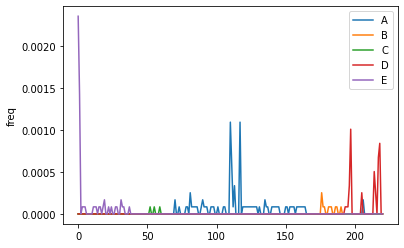

In [157]:
#A requirement

#B responsibility

#C benefit

#D apply resume

#E company description
import matplotlib.pyplot as plt
plt.plot(dist['A'], label="A")
plt.plot(dist['B'], label="B")
plt.plot(dist['C'], label="C")
plt.plot(dist['D'], label="D")
plt.plot(dist['E'], label="E")
plt.ylabel('freq')
plt.legend()
plt.show()

['E', 'A', 'B', 'D']


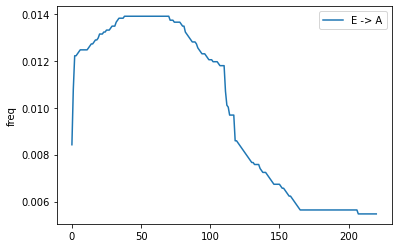

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


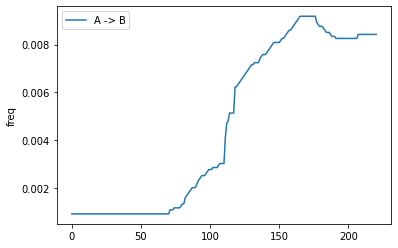

1
2
3
4
5
6
7
8
9
10
11
12


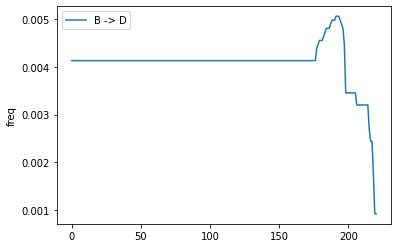

1
2
3
[0, 71, 177, 194, 220]


In [158]:
ordering = find_ordering(dist)
print(ordering)
spts = split_points(dist, ordering)
print(spts)

In [159]:
for idx in range(len(ordering)):
    section = ordering[idx]
    print(f'=== {section} ===')
    line = ' '.join([x['token'].split(' ')[0] for x in collection[spts[idx]:spts[idx+1]]])
    print(line)

=== E ===
our client is a well-known global technology company. we are looking for outstanding talents who are determined in developing their career in the digital marketing industry to. join our project for a global renowned advertising company. clear career path with attractive. salary package pleasant. company culture with renowned company background. work with a dynamic and friendly team in a. great location . job duties. collect requirements from end-users. design and develop
=== A ===
solutions to meet end-users requirement. work with other teammates to meet tight schedule / rapid changing business requirements. analyse and design systems for business problems. require excellent programming skills and customer thinking mindset. requirements. graduate work or degree in computer science or engineering a plus. hands on experience in apache spark / scala / presto / elasticsearch / hdfs is a definitely plus. knowledge in java, spring, php, vue. js, jquery, linux shell, git, maven will

# Plots to inspect

In [17]:
# Plot Accumulated
accum = {
    'A': [],
    'B': [],
    'C': [],
    'D': [],
    'E': [],
}
for idx in range(0, len(dist['A'])):
    line = f"{idx} {sum(dist['A'][0:idx])} {sum(dist['B'][0:idx])} {sum(dist['C'][0:idx])}  {sum(dist['D'][0:idx])}  {sum(dist['E'][0:idx])}"
    accum['A'].append(sum(dist['A'][0:idx]))
    accum['B'].append(sum(dist['B'][0:idx]))
    accum['C'].append(sum(dist['C'][0:idx]))
    accum['D'].append(sum(dist['D'][0:idx]))
    accum['E'].append(sum(dist['E'][0:idx]))
    print(line)

0 0 0 0  0  0
1 0 8.4224711530363e-05 0  0  0
2 0 0.000168449423060726 0  0  0
3 0 0.000168449423060726 0  0  0
4 0 0.00084224711530363 0  0  0
5 0 0.0031163143266234312 0  0  0
6 0 0.0032005390381537944 0  0  0
7 0 0.0032847637496841576 0  0  0
8 0 0.003368988461214521 0  0  0
9 0 0.003368988461214521 0  0  0
10 0 0.003368988461214521 0  0  0
11 0 0.003453213172744884 0  0  0
12 0 0.0035374378842752473 0  0  0
13 0 0.0035374378842752473 0  0  0
14 0 0.0036216625958056105 0  0  0
15 0 0.0037058873073359737 0  0  0
16 0 0.003790112018866337 0  0  0
17 0 0.0038743367303967 0  0  0
18 0 0.0038743367303967 0  0  0
19 0 0.0038743367303967 0  0  0
20 0 0.003958561441927063 0  0  0
21 0 0.003958561441927063 0  0  0
22 0 0.003958561441927063 0  0  0
23 0 0.004211235576518152 0  0  0
24 0 0.004211235576518152 0  0  0
25 0 0.004295460288048515 0  0  0
26 0 0.004295460288048515 0  0  0
27 0 0.004295460288048515 0  0  0
28 0 0.004295460288048515 0  0  0
29 0 0.009295460288048514 0  0  0
30 0 0.014

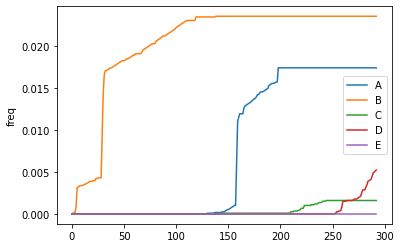

In [92]:
#A requirement

#B responsibility

#C benefit

#D apply resume

#E company description
import matplotlib.pyplot as plt
plt.plot(accum['A'], label="A")
plt.plot(accum['B'], label="B")
plt.plot(accum['C'], label="C")
plt.plot(accum['D'], label="D")
plt.plot(accum['E'], label="E")
plt.ylabel('freq')
plt.legend()
plt.show()


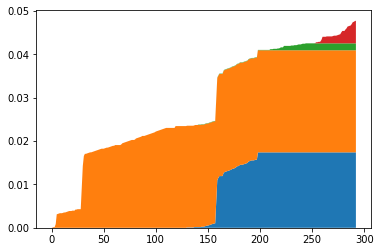

In [93]:
import pandas as pd
plt.stackplot(range(len(accum['A'])),[accum[x] for x in accum.keys()], labels=['A','B','C','D','E'])

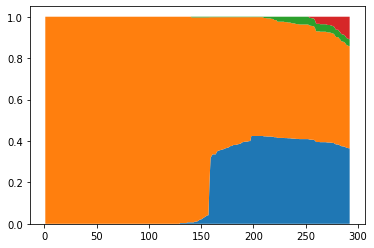

In [20]:
# Make data
data = pd.DataFrame(accum, index=range(len(accum['A'])))
 
# We need to transform the data from raw data to percentage (fraction)
data_perc = data.divide(data.sum(axis=1), axis=0)
plt.stackplot(range(len(accum['A'])),[data_perc[x] for x in data_perc.keys()], labels=['A','B','C','D','E'])